In [1]:
import numpy as np
import pandas 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pynbody 
from sklearn.metrics import confusion_matrix

import torch 
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from nflows import transforms
from torchvision.transforms.functional import resize
from nflows.transforms.base import Transform

# Put cataloge (AHF) and simulation (output) in the same folder

# Load the simuation

In [2]:
s = pynbody.load('data/g8.26e11/snap_2000/output/8.26e11.02000') #this is a SimSnap
h = s.halos() #this is a cataloghue

In [3]:
print('number of particles in h[1]:', len(h[1]))
print('number of particles in h[-1]:', len(h[len(h)]))

number of particles in h[1]: 9579299
number of particles in h[-1]: 50


In [4]:
s.physical_units()

In [5]:
h1 = h[1]
print('len star', len(h1.s), '\t', 'len gas', len(h1.g), '\t', 'len dark matter', len(h1.d))
print('total number of particles', (len(h1.s) + len(h1.g) + len(h1.d)))

len star 4171413 	 len gas 1665173 	 len dark matter 3742713
total number of particles 9579299


# Plot 
halos must be centered before plotting

### Plot of h1 (main halo)

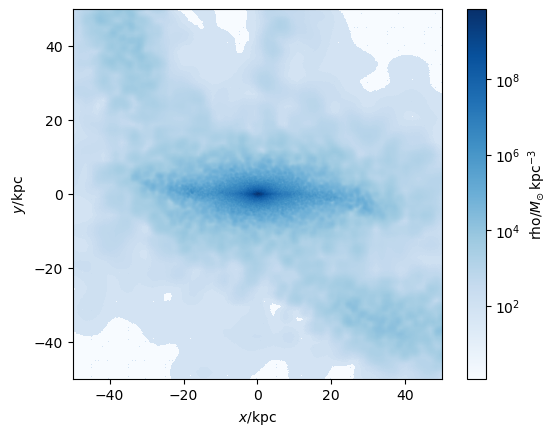

In [7]:
#Edge on
pynbody.analysis.halo.center(h1,mode='hyb')
pynbody.analysis.angmom.sideon(h[1])
pynbody.plot.image(h1.s, width=100, cmap='Blues');

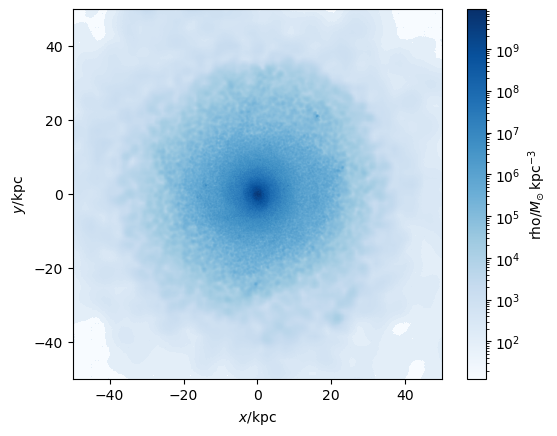

In [8]:
#Face on
pynbody.analysis.angmom.faceon(h[1])
pynbody.plot.image(h[1].s, width=100, cmap='Blues');

### Plot of h[2]

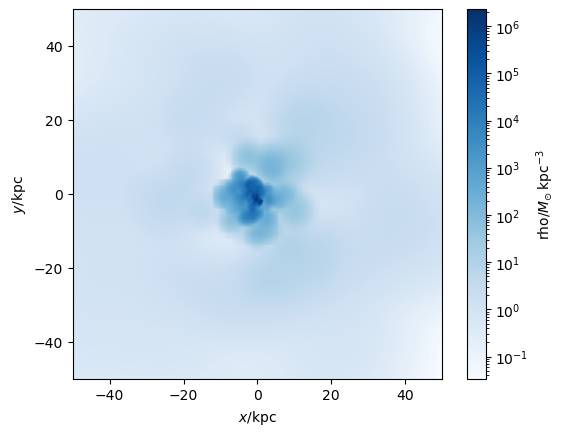

In [9]:
pynbody.analysis.halo.center(h[2],mode='hyb')
pynbody.plot.image(h[2].s, width=100, cmap='Blues');

### Profile of density and circular velocity

Text(0, 0.5, '$\\Sigma$ [M$_\\odot$/ kpc$^2$]')

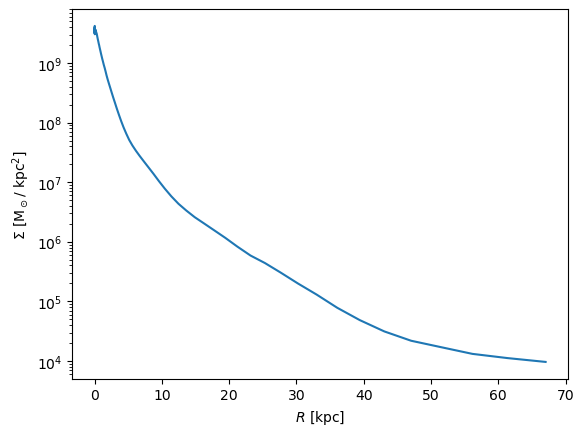

In [10]:
pynbody.analysis.angmom.faceon(h[1])
ps = pynbody.analysis.profile.Profile(h1.s, min = 0.01, max = 70, type = 'log')
plt.plot(ps['rbins'], ps['density'])
plt.semilogy()
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$\Sigma$ [M$_\odot$/ kpc$^2$]');

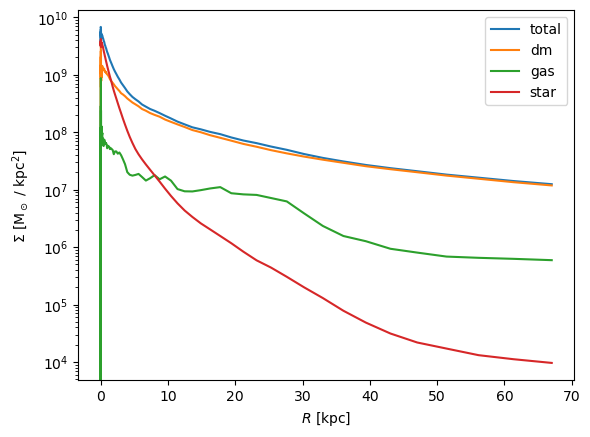

In [11]:
ps = pynbody.analysis.profile.Profile(h1.s, min=0.01, max=70, type='log')
pg = pynbody.analysis.profile.Profile(h1.g, min=0.01, max=70, type='log')
pd = pynbody.analysis.profile.Profile(h1.d, min=0.01, max=70, type='log')
p = pynbody.analysis.profile.Profile(h1, min=0.01, max=70, type='log')

for prof, name in zip([p, pd, pg, ps], ['total', 'dm', 'gas', 'star']):
    plt.plot(prof['rbins'], prof['density'], label=name)
plt.semilogy()
plt.legend()
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$\Sigma$ [M$_\odot$ / kpc$^2$]');

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


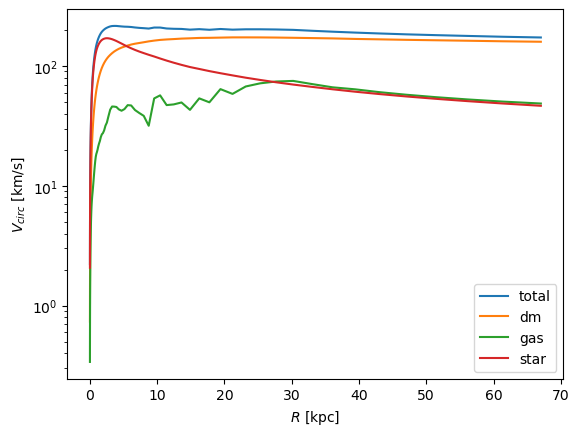

In [12]:
ps = pynbody.analysis.profile.Profile(h1.s, min=0.01, max=70, type='log')
pg = pynbody.analysis.profile.Profile(h1.g, min=0.01, max=70, type='log')
pd = pynbody.analysis.profile.Profile(h1.d, min=0.01, max=70, type='log')
p = pynbody.analysis.profile.Profile(h1, min=0.01, max=70, type='log')

for prof, name in zip([p, pd, pg, ps], ['total', 'dm', 'gas', 'star']):
    plt.plot(prof['rbins'], prof['v_circ'], label=name)
plt.semilogy()
plt.legend()
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$V_{circ}$ [km/s]');

# Distribution of the whole simulation (no distinction between different halos)

In [13]:
print(s.s.loadable_keys())

['mass', 'pos', 'timeform', 'metals', 'massform', 'OxMassFrac', 'eps', 'vel', 'FeMassFrac', 'phi', 'HI', 'tform', 'HeII', 'HeI', 'iord', 'igasorder']


In [13]:
print(s.derivable_keys())

['HII', 'HeIII', 'ne', 'hetot', 'hydrogen', 'feh', 'oxh', 'ofe', 'mgfe', 'nefe', 'sife', 'c_s', 'c_s_turb', 'mjeans', 'mjeans_turb', 'ljeans', 'ljeans_turb', 'r', 'rxy', 'vr', 'v2', 'vt', 'ke', 'te', 'j', 'j2', 'jz', 'vrxy', 'vcxy', 'vphi', 'vtheta', 'v_mean', 'v_disp', 'v_curl', 'vorticity', 'v_div', 'age', 'u_mag', 'u_lum_den', 'b_mag', 'b_lum_den', 'v_mag', 'v_lum_den', 'r_mag', 'r_lum_den', 'i_mag', 'i_lum_den', 'j_mag', 'j_lum_den', 'h_mag', 'h_lum_den', 'k_mag', 'k_lum_den', 'U_mag', 'U_lum_den', 'B_mag', 'B_lum_den', 'V_mag', 'V_lum_den', 'R_mag', 'R_lum_den', 'I_mag', 'I_lum_den', 'J_mag', 'J_lum_den', 'H_mag', 'H_lum_den', 'K_mag', 'K_lum_den', 'theta', 'alt', 'az', 'cs', 'mu', 'p', 'u', 'temp', 'zeldovich_offset', 'aform', 'tform', 'iord_argsort', 'smooth', 'rho']


In [20]:
h[1].properties.keys()

dict_keys(['omegaM0', 'omegaL0', 'h', 'boxsize', 'a', 'time', 'halo_id', 'ID', 'hostHalo', 'numSubStruct', 'mass', 'npart', 'Xc', 'Yc', 'Zc', 'VXc', 'VYc', 'VZc', 'Rvir', 'Rmax', 'r2', 'mbp_offset', 'com_offset', 'Vmax', 'v_esc', 'sigV', 'lambda', 'lambdaE', 'Lx', 'Ly', 'Lz', 'b_axis', 'c_axis', 'Eax', 'Eay', 'Eaz', 'Ebx', 'Eby', 'Ebz', 'Ecx', 'Ecy', 'Ecz', 'ovdens', 'nbins', 'fMhires', 'Ekin', 'Epot', 'SurfP', 'Phi0', 'cNFW', 'n_gas', 'M_gas', 'lambda_gas', 'lambdaE_gas', 'Lx_gas', 'Ly_gas', 'Lz_gas', 'b_gas', 'c_gas', 'Eax_gas', 'Eay_gas', 'Eaz_gas', 'Ebx_gas', 'Eby_gas', 'Ebz_gas', 'Ecx_gas', 'Ecy_gas', 'Ecz_gas', 'Ekin_gas', 'Epot_gas', 'n_star', 'M_star', 'lambda_star', 'lambdaE_star', 'Lx_star', 'Ly_star', 'Lz_star', 'b_star', 'c_star', 'Eax_star', 'Eay_star', 'Eaz_star', 'Ebx_star', 'Eby_star', 'Ebz_star', 'Ecx_star', 'Ecy_star', 'Ecz_star', 'Ekin_star', 'Epot_star', 'fstart', 'children'])

In [21]:
h[1].properties['numSubStruct']

171

In [17]:
print(h[1].properties['children'])

[3082, 315, 2658, 1001, 2613, 2895, 1426, 1514, 2925, 1159, 1104, 885, 1134, 572, 2303, 1342, 2771, 730, 1942, 2668, 841, 1882, 1392, 1294, 1495, 385, 2025, 916, 1814, 1778, 1811, 1947, 1732, 2872, 696, 2682, 2534, 1949, 2593, 257, 3007, 1939, 694, 723, 1146, 1381, 444, 892, 610, 2294, 2417, 281, 242, 2473, 559, 1430, 2140, 461, 316, 1565, 2280, 1261, 931, 1836, 2195, 2604, 277, 1255, 2087, 2806, 588, 2407, 2400, 1745, 2784, 1312, 633, 569, 1038, 1199, 1333, 2667, 1965, 218, 1935, 1369, 37, 2385, 2569, 1397, 1985, 1112, 486, 2282, 211, 119, 1610, 1894, 1386, 2601, 829, 2796, 1938, 2775, 3138, 2430, 2345, 546, 1406, 2853, 1584, 425, 1212, 1324, 721, 524, 2126, 2502, 3, 1086, 452, 386, 2339, 693, 353, 1709, 2139, 2891, 2432, 1149, 1921, 1786, 3008, 1250, 804, 2867, 154, 928, 1188, 2899, 521, 772, 617, 658, 3096, 1332, 2679, 897, 1815, 1826, 2193, 2789, 1483, 2226, 920, 2920, 992, 468, 1686, 888, 306, 507, 713, 1348, 2639, 2259, 2203, 1011, 715, 1660, 54]


In [23]:
for i in h[1].properties['children']:
    print(i, len(h[i].s))

3082 0
315 0
2658 0
1001 0
2613 0
2895 0
1426 0
1514 0
2925 0
1159 0
1104 30
885 0
1134 0
572 0
2303 0
1342 0
2771 0
730 0
1942 0
2668 0
841 0
1882 0
1392 0
1294 0
1495 0
385 0
2025 0
916 0
1814 0
1778 0
1811 0
1947 0
1732 0
2872 0
696 0
2682 0
2534 0
1949 0
2593 0
257 0
3007 0
1939 0
694 0
723 0
1146 0
1381 0
444 0
892 0
610 0
2294 0
2417 0
281 0
242 0
2473 0
559 0
1430 0
2140 0
461 0
316 0
1565 0
2280 0
1261 0
931 0
1836 0
2195 0
2604 0
277 0
1255 0
2087 0
2806 0
588 0
2407 0
2400 0
1745 0
2784 0
1312 0
633 0
569 0
1038 0
1199 0
1333 0
2667 0
1965 0
218 272
1935 0
1369 0
37 605
2385 0
2569 0
1397 0
1985 0
1112 0
486 0
2282 0
211 0
119 0
1610 0
1894 0
1386 0
2601 0
829 25
2796 0
1938 0
2775 0
3138 0
2430 0
2345 0
546 0
1406 0
2853 0
1584 0
425 0
1212 0
1324 0
721 0
524 0
2126 0
2502 0
3 25214
1086 0
452 0
386 0
2339 0
693 0
353 0
1709 0
2139 0
2891 0
2432 0
1149 0
1921 0
1786 0
3008 0
1250 0
804 0
2867 0
154 0
928 0
1188 0
2899 0
521 0
772 0
617 0
658 0
3096 0
1332 0
2679 0
897 0
1815

In [54]:
host_halo_id = []
for i, h_i in enumerate(h):
    if h_i.properties['hostHalo'] == -1:
        host_halo_id.append(i+1)

print('Number of halos:', len(h))
print('Numeber of host_halo:', len(host_halo_id))

Number of halos: 3139
Numeber of host_halo: 2856


## Fe/H O/H 
Halo Catalogue, AHF is the halo finder

In [56]:
feh = s.s['feh']
ofe = s.s['ofe']

print(len(s.s))
print(len(feh))
print(len(ofe))

4235419
4235419
4235419


In [61]:
feh_array = np.array(feh)
ofe_array = np.array(ofe)

#let's take the 99.9 percentile 
percentile_feh = np.percentile(feh_array, 1)
percentile_ofe = np.percentile(ofe_array, 1)
print(percentile_feh)
print(percentile_ofe)

-1.7661555913200726
-0.1851269006729126


In [62]:
df = pandas.DataFrame(data=(zip(feh_array[feh_array>percentile_feh], ofe_array[ofe_array>percentile_ofe])),
                  columns= ['Fe/H', 'O/Fe'])

Text(0.5, 0, 'O/Fe')

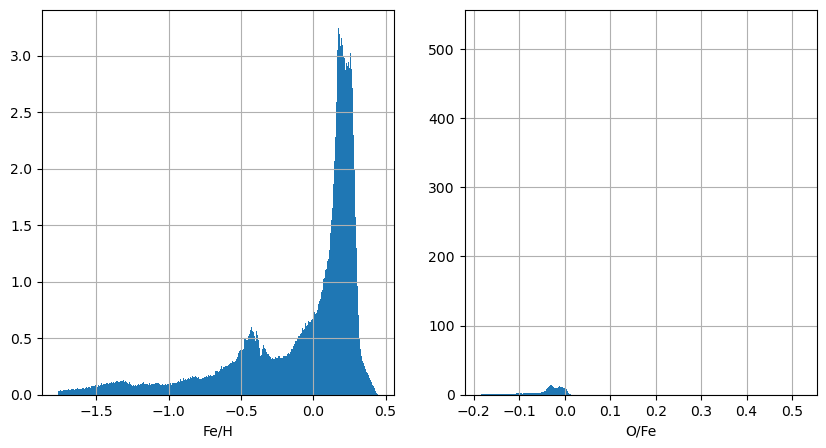

In [63]:
fig, (ax0, ax1)= plt.subplots(figsize=(10,5), nrows=1, ncols=2)
df['Fe/H'].hist(ax=ax0, bins = int(np.sqrt(len(df['Fe/H']))), density=True)
ax0.set_xlabel('Fe/H')

df['O/Fe'].hist(ax=ax1, bins = int(np.sqrt(len(df['O/Fe']))), density=True)
ax1.set_xlabel('O/Fe')

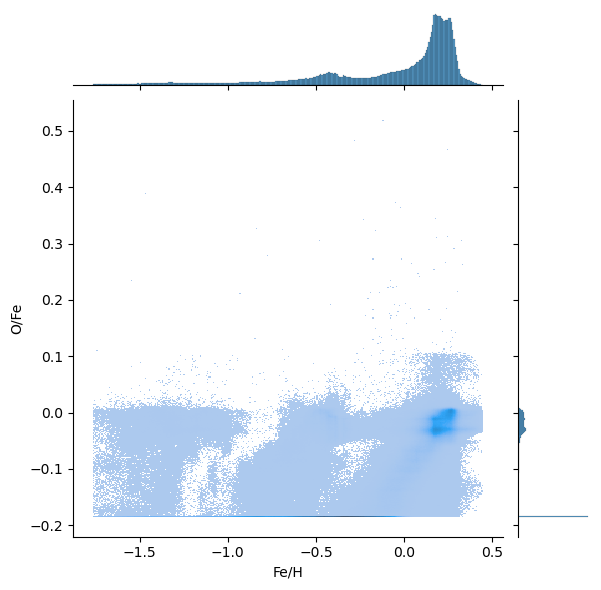

In [64]:
sns.jointplot(data=df, x='Fe/H', y='O/Fe', kind='hist')

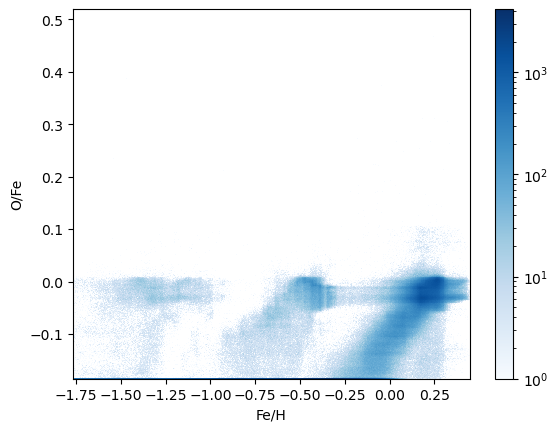

In [66]:
plt.hist2d(df['Fe/H'], df['O/Fe'], bins=(500, 500), norm=matplotlib.colors.LogNorm(), cmap='Blues')
plt.colorbar()
plt.xlabel('Fe/H')
plt.ylabel('O/Fe')
plt.show()

## Masform timeform

In [21]:
mass_form = s.s['massform']
time_form = s.s['timeform']

Text(0, 0.5, 'mass form')

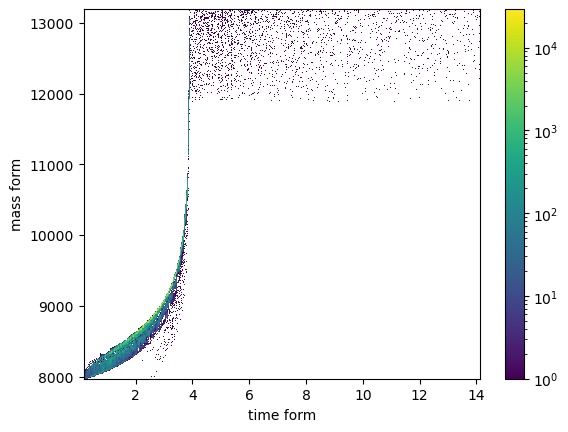

In [25]:
plt.hist2d(time_form, mass_form, bins=(500, 500), norm=matplotlib.colors.LogNorm());
plt.colorbar()
plt.xlabel('time form')
plt.ylabel('mass form')